In [1]:
import geopandas as gpd
from osgeo import ogr
import pandas as pd
import tifffile as tiff #needed for the tif data for perry county
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from math import sin, cos, sqrt, atan2, radians
import sys
from shapely.geometry import Polygon, box, Point, LineString, MultiLineString
import pickle
import gurobipy as gp
from gurobipy import GRB
import tifffile as tiff #needed for the tif data for perry county
import xlwt
from xlwt import Workbook
from shapely.ops import snap, split, nearest_points
#from shapely.geometry import MultiPoint, LineString
#from dbfread import DBF
import osmnx as ox
import networkx as nx
import math
import gurobipy as gp
from gurobipy import GRB
import os
import csv
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

In [2]:
# calculate distance
def haversinedist(lat1, lon1, lat2, lon2):
    R = 6373.0
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    return distance #unit in km

In [3]:
# read data
def readClusterFile(fileID):
    file = np.genfromtxt(fileID, delimiter=",", skip_header = 1)
    file = file[:,1:]
    return file
clusterfile = 'Centralized_elevcluster' + str(1) + '.csv'

In [4]:
# read data
def readClusterFile(fileID):
    file = np.genfromtxt(fileID, delimiter=",", skip_header = 1)
    file = file[:,1:]
    return file
clusterfile = 'Centralized_elevcluster' + str(1) + '.csv'
building_coords = readClusterFile(clusterfile)

In [5]:
# pipe parameters
pipesize = [0.05, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6] #m
pipesize_str, pipecost = gp.multidict({'0.05': 8.7, '0.06': 9.5, '0.08': 11, \
                                                   '0.1': 12.6, '0.15': 43.5,'0.2': 141, '0.25': 151, '0.3': 161, '0.35':230, '0.4': 246, '0.45':262, 
                                                   '0.5':292, '0.6':315}) #$/m
excavation = 25
bedding_cost_sq_ft = 6
capital_cost_pump_station = 166000
ps_flow_cost = 0.19
ps_OM_cost = 175950

In [6]:
# creat MST

graph = []
mstree = []
def createMSTnx(dataframe,n):
    #only takes longitude and latitude from the cluster data, note we also have elevation and stuff there too
    #coordinates = twoDcluster
    cluster = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    cluster.fit_predict(building_coords[:,1:2])
    # add cluster to dataframe
    dataframe['cluster.labels_'] = cluster.labels_.tolist()
    for k in range(n):
        cluster_label = dataframe[dataframe['cluster.labels_'] == k]
        cluster_label = cluster_label[['longitude','latitude']]
        latlon = cluster_label.to_numpy()
        nrows, ncols = latlon.shape
        #creates graph
        graph.append(nx.Graph())
        weights = []
        #distance in km as weight between each point in the graph
        for i in range(nrows):
            graph[k].add_node(i,pos=(latlon[i,0],latlon[i,1]))
            for j in range(i+1,nrows):
                dist = haversinedist(latlon[i,1], latlon[i,0], latlon[j,1], latlon[j,0])
                weights.append(dist)
                graph[k].add_edge(i,j, weight = dist)
        #creates MST
        mstree.append(nx.minimum_spanning_tree(graph[k]))
    return mstree, graph

In [7]:
#convert data to dataframe
df = pd.DataFrame(building_coords,
                  columns = ['longitude','latitude','elevation'])
createMSTnx(df,10)

([<networkx.classes.graph.Graph at 0x7f95ad017c10>,
  <networkx.classes.graph.Graph at 0x7f95887d4af0>])

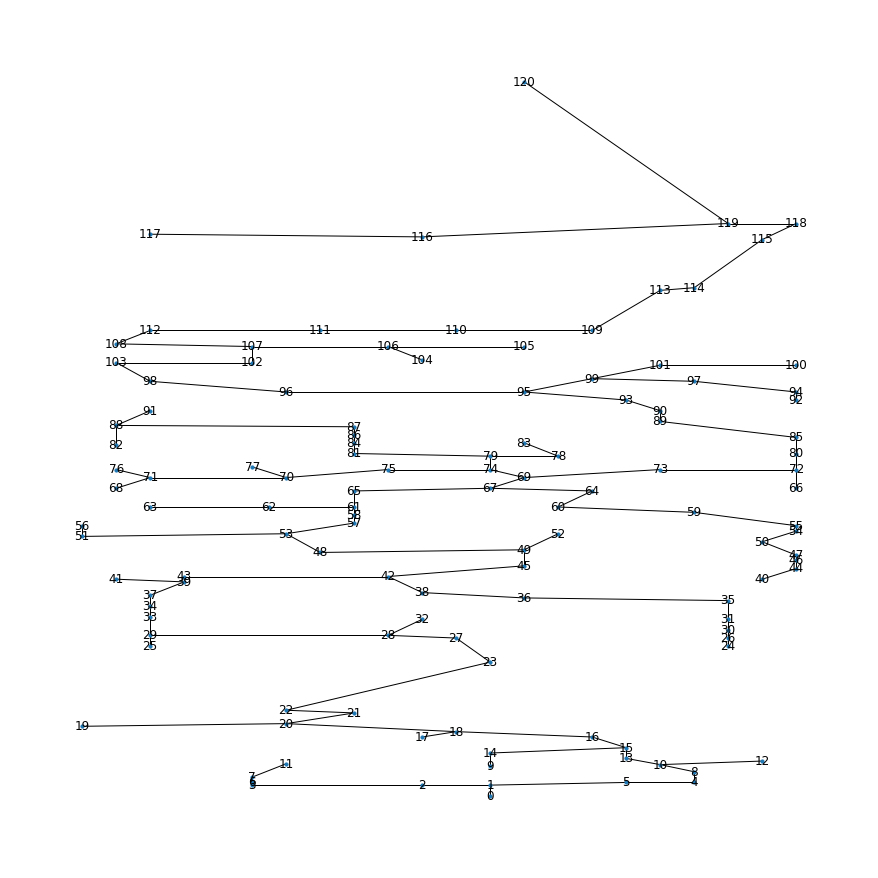

In [8]:
pos = {city:(long, lat) for (city, (lat,long)) in nx.get_node_attributes(mstree[7], 'pos').items()}
plt.figure(3,figsize=(12,12)) 
nx.draw(mstree[7], pos, with_labels=True, node_size=10)
plt.show()

In [9]:
def minlp(cluster_labels, pipesize, pipecost, water_demand, HLmax, excavation, bedding_cost_sq_ft, capital_cost_pump_station, ps_OM_cost):
    
    # select highest and lowest nodes in cluster
    tank = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmax()].reset_index(drop=True)
    trem = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmin()].reset_index(drop=True)
                      
     # find label of tank node in cluster
    tank_lon = str(tank[tank['cluster.labels_'] == cluster_labels][['longitude']].iat[0,0])
    tank_lat = str(tank[tank['cluster.labels_'] == cluster_labels][['latitude']].iat[0,0])
    for i in mstree[cluster_labels].nodes():
        if str(mstree[cluster_labels].nodes[i]['pos'][0]) == tank_lon and str(mstree[cluster_labels].nodes[i]['pos'][1]) == tank_lat:
            tank_node = i                  
    #create flow direction dict
    links = list(mstree[cluster_labels].edges)
    flow_dir = {}
    for i,j in links:
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) < len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node i is nearer to tank
           flow_dir[i,j]=(i,j)
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
         # if node j is nearer to tank
           flow_dir[i,j]=(j,i) 
    # find nodes for inflow and outflow
    innode = {}
    outnode = {}
    for i,j in links:
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
           # if node j is nearer to tank
            innode.setdefault(i, [])
            innode[i].append(j)
            outnode.setdefault(j, [])
            outnode[j].append(i)
        else:
           # if node i is nearer to tank
            innode.setdefault(j, [])
            innode[j].append(i)
            outnode.setdefault(i, [])
            outnode[i].append(j)
    for i in mstree[cluster_labels].nodes():
        innode.setdefault(i,[])
        outnode.setdefault(i, [])
   # directed graph
    mstree_dir = nx.DiGraph()
    mstree_dir.add_nodes_from(mstree[cluster_labels])
    mstree_dir.add_edges_from(flow_dir.values())
    weights = {}
    for i in list(mstree_dir.edges()):
        weights[i] = None
    for i,j in flow_dir:
        if flow_dir[i,j]==(i,j):
            weights[i,j]=mstree[cluster_labels].edges[i,j]['weight']
        if flow_dir[i,j]==(j,i):
            weights[j,i]=mstree[cluster_labels].edges[i,j]['weight']
    nx.set_edge_attributes(mstree_dir, values = 1, name = 'weight')
    nx.set_edge_attributes(mstree_dir, values = weights, name = 'weight')
    # determine iterate order
    walk = {}
    for i,j in mstree_dir.edges():
        walk[i,j] = len(nx.shortest_path(mstree_dir ,source=tank_node, target=j))
    sorted_walk = dict(sorted(walk.items(), key=lambda item: item[1], reverse = True))
    # pipe flow
    pipe_flow = {}
    for i,j in sorted_walk:
        if len(outnode[j]) == 0:
            pipe_flow[i,j] = 1.095E-5
        else:
            pipe_flow[i,j] = sum(pipe_flow[m,n] for m,n in sorted_walk if m == j) + 1.095E-5
    # head loss at largest dia        
    head_loss = {}
    for i in list(mstree_dir.edges()):
        head_loss[i] = None
    for i,j in list(mstree_dir.edges()):
        head_loss[i,j] = 10700*(pipe_flow[i,j]/140)**1.852*0.6*1000*mstree_dir[i][j]["weight"]
    # flow, distance and head loss for each edge
    edge_list = {}
    for i,j in links:
        if (i,j) == flow_dir[i,j]:
            edge_list[i,j] =[pipe_flow[i,j],mstree[cluster_labels][i][j]["weight"], head_loss[i,j]]
        else:
            edge_list[j,i] =[pipe_flow[j,i],mstree[cluster_labels][i][j]["weight"], head_loss[j,i]]
   #node elevation excavation in meters
   #upper bound is arbritrary maximum depth assuming 1 foot or 0.3048 meters of cover beneath the surface is needed for the pipes
   #a lower bound variable is created but not used. In future models might need to implement that depending on the site (digging too deep for excavation is not feasible for many projects)
    cluster = df[df['cluster.labels_'] == cluster_labels]
    cluster_elv = cluster[['elevation']]
    elevation_ub = dict()
    elevation_lb = dict()
    for i in range(mstree[cluster_labels].number_of_nodes()):
        elevation_ub[i] = cluster_elv.iloc[[0]] + 1e+5
        elevation_lb[i] = cluster_elv.iloc[[0]] - 1e+5  
    #for i in range(mstree[cluster_labels].number_of_nodes()):
       # elevation_ub[i] = cluster_elv.iloc[[0]] - 0.3048
        #elevation_lb[i] = cluster_elv.iloc[[0]] - 30  
    m = gp.Model('pipe and pump distribution')
    m.Params.timeLimit = 12000
   # binary variable indicating if at link ij pipe of diameter k is implemented
    d = m.addVars(mstree_dir.edges(), pipesize, vtype = GRB.BINARY, name = "diameter")
   #continuous variable representing the hydro loss in link ij.
    HL = m.addVars(mstree_dir.edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "hydro loss")
    # hydro gradient
    #J = m.addVars(mstree[cluster_labels].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "hydro gradient")
   # binary variable indicating if at link ij the pump of type m is implemented.
    p = m.addVars(mstree_dir.edges(), vtype = GRB.BINARY, name = "PUMP")
   #continuous variable representing the pressure injected by the pump at link ij.
    pr = m.addVars(mstree_dir.edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "PRESSURE BY PUMP")
   #pipe elevations at node i 
    e = m.addVars(mstree_dir.nodes(), lb = 0, vtype = GRB.CONTINUOUS, name = 'In Node Elevation')
   #continuous variable representing the head pressure at node i
    H = m.addVars(mstree_dir.nodes(),lb = 0, vtype = GRB.CONTINUOUS, name = "HEAD PRESSURE")
    for i,j in mstree_dir.edges():
#Hazen Williams equation, A = 10700, C=140, P472
        #m.addConstr(J[i,j] == 
                #10700*(edge_list[i,j][0]/140)**1.852*gp.quicksum(d[i,j,k]/(k**4.8704) for k in pipesize)
               #, "Hydro loss")
        m.addConstr(HL[i,j] == 10700*(edge_list[i,j][0]/140)**1.852*gp.quicksum(d[i,j,k]/(k**4.8704) for k in pipesize)*1000*mstree_dir[i][j]["weight"])
        m.addConstr(HL[i,j] <= HLmax)
#only one pipe per edge
        m.addConstr((d.sum(i, j, '*') == 1.0), "single size chosen")
#injected pressure pr[i,j] must be less than a huge number.
        m.addConstr(pr[i,j]<=p[i,j]*10**6)
    # energy requirement
        m.addConstr(H[j] == H[i] - HL[i,j] + e[i] - e[j] + pr[i,j], "Energy balance")
    
        #if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) < len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node i is nearer to tank        
            #m.addConstr(H[j] == H[i] -HL[i,j] + e[i] - e[j] + pr[i,j], "Energy balance")
        #if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node j is nearer to tank        
            #m.addConstr(H[i] == H[j] -HL[i,j] + e[j] - e[i] + pr[i,j], "Energy balance")
# Velocity must be between 0.6 and 3 m/s to 30
        m.addConstr((
           edge_list[i,j][0] <= ((3.14/4)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 3), "Velocity Max Constr"+ str([i,j]))
        #m.addConstr((
           #edge_list[i,j][0] >= ((3.14/4)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 0.6), "Velocity Min Constr" + str([i,j]))  
    #for i in mstree_dir.nodes():
#pipe elevation must be betwenn lb and ub
        m.addConstr(e[i] >= float(str(elevation_lb[i])[20:]), "PIPE ELV LB")
        m.addConstr(e[i] <= float(str(elevation_ub[i])[20:]), "PIPE ELV UB")
    
        m.addConstr(H[i] >= 31.646232670592248, "Min head pressure") #45 psi, covert it to m
        m.addConstr(H[i] <= 56.26, "Max head pressure") #80 psi, covert it to m
        
    m.addConstr(H[tank_node] == 31.646232670592248)
                      
                      
    # pipe cost 
    obj1 = gp.quicksum(1000 * mstree_dir[i][j]["weight"] * gp.quicksum(pipecost[str(k)] * d[i, j, k] 
                                                           for k in pipesize) for i,j in mstree_dir.edges())
    # Capital cost of pump stations
    obj2 = gp.quicksum(p.sum(i, j) * capital_cost_pump_station for i,j in mstree_dir.edges())

    #Operation and maintenance costs
    obj3 = gp.quicksum(p.sum(i, j)*ps_OM_cost for i, j in mstree_dir.edges())

    obj = obj1+obj2+obj3                  
    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()
    
    # record dia
    #count = 0
    #for i, j in mstree_dir.edges():
        #for k in range(len(pipesize)):
            #if m.getVars()[k+count].X == 1:
                #edge_list[i,j].append(pipesize[k])
        #count = count + len(pipesize)
    #d = []
    #for i,j in mstree_dir.edges():
        #d.append(edge_list[i,j][3])
    #edge_dia = {}
    #count = 0
    #for i,j in links:
        #edge_dia[i,j]=d[count]
        #count = count+1    
    
    #plot
    plt.figure(3,figsize=(12,12)) 
    plot = nx.draw(mstree_dir,width=1, with_labels=True)
    #pos = nx.spring_layout(mstree[9])
    #nx.draw_networkx(mstree[9], pos)
    #nx.draw_networkx_edge_labels(mstree_dir, pos, edge_labels=edge_dia,label_pos=0.5, font_size=8)
    
    #save the result
    modelname = "pipe&pump distri" + str(cluster_labels) + ".csv" 
        #m.write(modelname)
    modelfile = open(modelname, "w")
    #modelfile.write("pipecost" + str(pipecost))
    modelfile.write('number of nodes: %g \n' % len(mstree[cluster_labels].nodes()))
    modelfile.write('number of edges: %g \n' % len(mstree[cluster_labels].edges()))
    #modelfile.write('number of continuous variables: %g \n' % (2*len(mstree[cluster_labels].edges()) + 2*len(mstree[cluster_labels].nodes()))
    #modelfile.write('number of binary variables: %g \n' % 2*len(mstree[cluster_labels].edges()))
    modelfile.write('capital_cost_pump_station: %g \n' % capital_cost_pump_station)
    modelfile.write('ps_OM_cost: %g \n' % ps_OM_cost)
    modelfile.write('water_demand: %g \n' % water_demand)
    modelfile.write('Solution Value: %g \n' % m.objVal)
    modelfile.write('Solution Value 1: %g \n' % obj1.getValue())
    modelfile.write('Solution Value 2: %g \n'% obj2.getValue())
    modelfile.write('Solution Value 3: %g \n'% obj3.getValue())                  
    for v in m.getVars():
        modelfile.write('%s %g \n' % (str(v.varName), v.x))
    modelfile.close()
    
    return obj.getValue(), obj1.getValue(), obj2.getValue(), obj3.getValue(), edge_list, plot
                      

Set parameter Username
Academic license - for non-commercial use only - expires 2022-09-18
Set parameter TimeLimit to value 12000
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1201 rows, 2162 columns and 6361 nonzeros
Model fingerprint: 0x14ba4821
Variable types: 482 continuous, 1680 integer (1680 binary)
Coefficient statistics:
  Matrix range     [2e-07, 1e+06]
  Objective range  [8e+01, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 4.180305e+07
Presolve removed 919 rows and 657 columns
Presolve time: 0.01s
Presolved: 282 rows, 1505 columns, 2909 nonzeros
Found heuristic solution: objective 3.103067e+07
Variable types: 189 continuous, 1316 integer (1316 binary)

Root relaxation: objective 5.037598e+0

(50375.98146527196,
 50375.98146527196,
 0.0,
 0.0,
 {(1, 0): [1.095e-05, 0.034763158168930795, 1.5382257568437836e-08],
  (1, 2): [5.475e-05, 0.020598117266494964, 1.7956464407581438e-07],
  (5, 1): [7.664999999999999e-05, 0.042102960134877195, 6.844394847550515e-07],
  (2, 3): [4.38e-05, 0.051495293154562916, 2.9695011206133827e-07],
  (3, 6): [3.285e-05, 0.008690852058957388, 2.9416552620175965e-08],
  (4, 5): [8.759999999999999e-05,
   0.020598117266494964,
   4.2879630754586485e-07],
  (8, 4): [9.854999999999998e-05, 0.034762943826442114, 9.00066357086899e-07],
  (6, 7): [2.19e-05, 0.017381704114330775, 2.776519701134107e-08],
  (7, 11): [1.095e-05, 0.044658049721834306, 1.9760621862581685e-08],
  (10, 8): [0.00010949999999999998, 0.0253607077930826, 7.981090305132827e-07],
  (14, 9): [1.095e-05, 0.04345394770279244, 1.922782195684321e-08],
  (13, 10): [0.00013139999999999997,
   0.02274389434294683,
   1.0032504230839757e-06],
  (10, 12): [1.095e-05, 0.032998620051887244, 1.46014

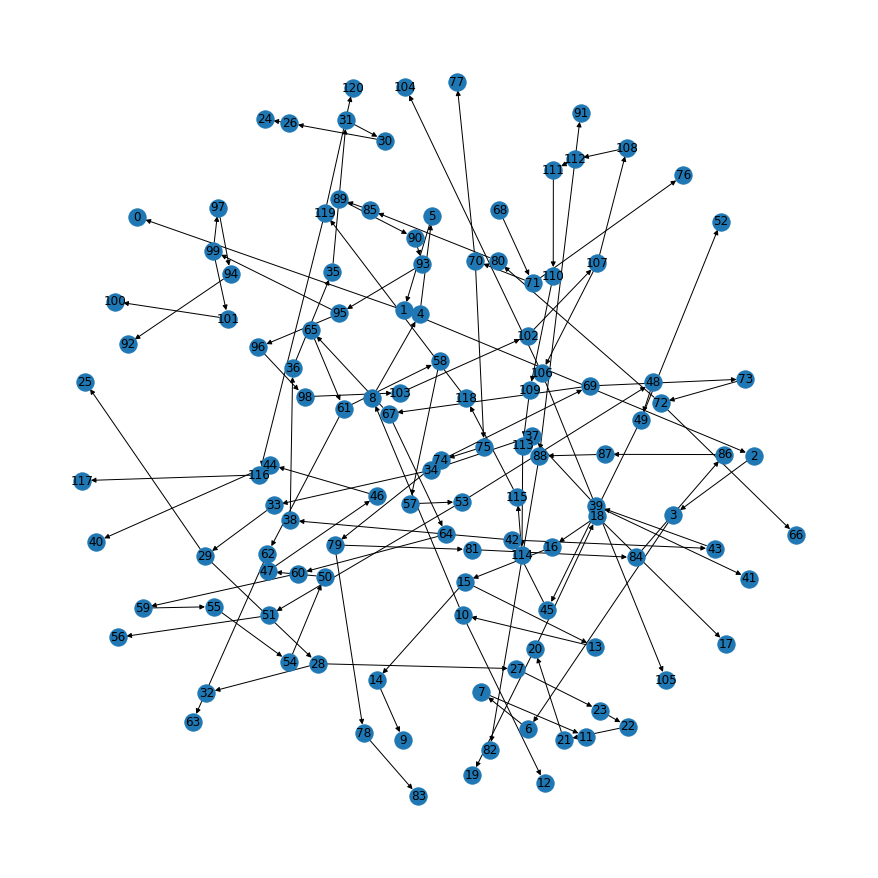

In [10]:
minlp(7, pipesize, pipecost, 1.095E-5, 1e+5, excavation, bedding_cost_sq_ft, capital_cost_pump_station, ps_OM_cost)

In [11]:
os.chdir("/Users/yuelanzhu/Downloads/Research/my code file")

In [43]:
def GEcheck(cluster_labels, pipesize, pipecost, water_demand, HLmax, excavation, bedding_cost_sq_ft, capital_cost_pump_station, ps_OM_cost):

    # select highest and lowest nodes in cluster
    tank = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmax()].reset_index(drop=True)
    trem = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmin()].reset_index(drop=True)
                      
     # find label of tank node in cluster
    tank_lon = str(tank[tank['cluster.labels_'] == cluster_labels][['longitude']].iat[0,0])
    tank_lat = str(tank[tank['cluster.labels_'] == cluster_labels][['latitude']].iat[0,0])
    for i in mstree[cluster_labels].nodes():
        if str(mstree[cluster_labels].nodes[i]['pos'][0]) == tank_lon and str(mstree[cluster_labels].nodes[i]['pos'][1]) == tank_lat:
            tank_node = i                  
    #create flow direction dict
    links = list(mstree[cluster_labels].edges)
    flow_dir = {}
    for i,j in links:
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) < len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node i is nearer to tank
           flow_dir[i,j]=(i,j)
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
         # if node j is nearer to tank
           flow_dir[i,j]=(j,i) 
    # find nodes for inflow and outflow
    innode = {}
    outnode = {}
    for i,j in links:
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
           # if node j is nearer to tank
            innode.setdefault(i, [])
            innode[i].append(j)
            outnode.setdefault(j, [])
            outnode[j].append(i)
        else:
           # if node i is nearer to tank
            innode.setdefault(j, [])
            innode[j].append(i)
            outnode.setdefault(i, [])
            outnode[i].append(j)
    for i in mstree[cluster_labels].nodes():
        innode.setdefault(i,[])
        outnode.setdefault(i, [])
   # directed graph
    mstree_dir = nx.DiGraph()
    mstree_dir.add_nodes_from(mstree[cluster_labels])
    mstree_dir.add_edges_from(flow_dir.values())
    weights = {}
    for i in list(mstree_dir.edges()):
        weights[i] = None
    for i,j in flow_dir:
        if flow_dir[i,j]==(i,j):
            weights[i,j]=mstree[cluster_labels].edges[i,j]['weight']
        if flow_dir[i,j]==(j,i):
            weights[j,i]=mstree[cluster_labels].edges[i,j]['weight']
    nx.set_edge_attributes(mstree_dir, values = 1, name = 'weight')
    nx.set_edge_attributes(mstree_dir, values = weights, name = 'weight')
    # determine iterate order
    walk = {}
    for i,j in mstree_dir.edges():
        walk[i,j] = len(nx.shortest_path(mstree_dir ,source=tank_node, target=j))
    sorted_walk = dict(sorted(walk.items(), key=lambda item: item[1], reverse = True))
    # pipe flow
    pipe_flow = {}
    for i,j in sorted_walk:
        if len(outnode[j]) == 0:
            pipe_flow[i,j] = 1.095E-5
        else:
            pipe_flow[i,j] = sum(pipe_flow[m,n] for m,n in sorted_walk if m == j) + 1.095E-5
    # head loss at largest dia        
    head_loss = {}
    for i in list(mstree_dir.edges()):
        head_loss[i] = None
    for i,j in list(mstree_dir.edges()):
        head_loss[i,j] = 10700*(pipe_flow[i,j]/140)**1.852*0.6*1000*mstree_dir[i][j]["weight"]
    # flow, distance and head loss for each edge
    edge_list = {}
    for i,j in links:
        if (i,j) == flow_dir[i,j]:
            edge_list[i,j] =[pipe_flow[i,j],mstree[cluster_labels][i][j]["weight"], head_loss[i,j]]
        else:
            edge_list[j,i] =[pipe_flow[j,i],mstree[cluster_labels][i][j]["weight"], head_loss[j,i]]
   #node elevation excavation in meters
   #upper bound is arbritrary maximum depth assuming 1 foot or 0.3048 meters of cover beneath the surface is needed for the pipes
   #a lower bound variable is created but not used. In future models might need to implement that depending on the site (digging too deep for excavation is not feasible for many projects)
    cluster = df[df['cluster.labels_'] == cluster_labels]
    cluster_elv = cluster[['elevation']]
    elevation_ub = dict()
    elevation_lb = dict()
    
    GE=float(str(sorted(cluster_elv.values.tolist())[120])[1:-1])
    
    for i in range(mstree[cluster_labels].number_of_nodes()):
        elevation_ub[i] = GE + 1e-5
        elevation_lb[i] = GE - 1e-5  
    #for i in range(mstree[cluster_labels].number_of_nodes()):
       # elevation_ub[i] = cluster_elv.iloc[[0]] - 0.3048
        #elevation_lb[i] = cluster_elv.iloc[[0]] - 30
        
    m = gp.Model('pipe and pump distribution')
    m.Params.timeLimit = 12000
   # binary variable indicating if at link ij pipe of diameter k is implemented
    d = m.addVars(mstree_dir.edges(), pipesize, vtype = GRB.BINARY, name = "diameter")
   #continuous variable representing the hydro loss in link ij.
    HL = m.addVars(mstree_dir.edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "hydro loss")
    # hydro gradient
    #J = m.addVars(mstree[cluster_labels].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "hydro gradient")
   # binary variable indicating if at link ij the pump of type m is implemented.
    p = m.addVars(mstree_dir.edges(), vtype = GRB.BINARY, name = "PUMP")
   #continuous variable representing the pressure injected by the pump at link ij.
    pr = m.addVars(mstree_dir.edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "PRESSURE BY PUMP")
   #pipe elevations at node i 
    e = m.addVars(mstree_dir.nodes(), lb = 0, vtype = GRB.CONTINUOUS, name = 'In Node Elevation')
   #continuous variable representing the head pressure at node i
    H = m.addVars(mstree_dir.nodes(),lb = 0, vtype = GRB.CONTINUOUS, name = "HEAD PRESSURE")
    for i,j in mstree_dir.edges():
#Hazen Williams equation, A = 10700, C=140, P472
        #m.addConstr(J[i,j] == 
                #10700*(edge_list[i,j][0]/140)**1.852*gp.quicksum(d[i,j,k]/(k**4.8704) for k in pipesize)
               #, "Hydro loss")
        m.addConstr(HL[i,j] == 10700*(edge_list[i,j][0]/140)**1.852*gp.quicksum(d[i,j,k]/(k**4.8704) for k in pipesize)*1000*mstree_dir[i][j]["weight"])
        m.addConstr(HL[i,j] <= HLmax)
#only one pipe per edge
        m.addConstr((d.sum(i, j, '*') == 1.0), "single size chosen")
#injected pressure pr[i,j] must be less than a huge number.
        m.addConstr(pr[i,j]<=p[i,j]*10**6)
    # energy requirement
        m.addConstr(H[j] == H[i] - HL[i,j] + e[i] - e[j] + pr[i,j], "Energy balance")
    
        #if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) < len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node i is nearer to tank        
            #m.addConstr(H[j] == H[i] -HL[i,j] + e[i] - e[j] + pr[i,j], "Energy balance")
        #if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node j is nearer to tank        
            #m.addConstr(H[i] == H[j] -HL[i,j] + e[j] - e[i] + pr[i,j], "Energy balance")
# Velocity must be between 0.6 and 3 m/s to 30
        m.addConstr((
           edge_list[i,j][0] <= ((3.14/4)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 3), "Velocity Max Constr"+ str([i,j]))
        #m.addConstr((
           #edge_list[i,j][0] >= ((3.14/4)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 0.6), "Velocity Min Constr" + str([i,j]))  
    for i in mstree_dir.nodes():
#pipe elevation must be betwenn lb and ub
        m.addConstr(e[i] >= elevation_lb[i], "PIPE ELV LB")
        m.addConstr(e[i] <= elevation_ub[i], "PIPE ELV UB")
    
        m.addConstr(H[i] >= 31.646232670592248, "Min head pressure") #45 psi, covert it to m
        m.addConstr(H[i] <= 56.26, "Max head pressure") #80 psi, covert it to m
        
    m.addConstr(H[tank_node] == 31.646232670592248)
                      
                      
    # pipe cost 
    obj1 = gp.quicksum(1000 * mstree_dir[i][j]["weight"] * gp.quicksum(pipecost[str(k)] * d[i, j, k] 
                                                           for k in pipesize) for i,j in mstree_dir.edges())
    # Capital cost of pump stations
    obj2 = gp.quicksum(p.sum(i, j) * capital_cost_pump_station for i,j in mstree_dir.edges())

    #Operation and maintenance costs
    obj3 = gp.quicksum(p.sum(i, j)*ps_OM_cost for i, j in mstree_dir.edges())

    obj = obj1+obj2+obj3                  
    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()
    
    # record dia
    #count = 0
    #for i, j in mstree_dir.edges():
        #for k in range(len(pipesize)):
            #if m.getVars()[k+count].X == 1:
                #edge_list[i,j].append(pipesize[k])
        #count = count + len(pipesize)
    #d = []
    #for i,j in mstree_dir.edges():
        #d.append(edge_list[i,j][3])
    #edge_dia = {}
    #count = 0
    #for i,j in links:
        #edge_dia[i,j]=d[count]
        #count = count+1    
    
    #plot
    plt.figure(3,figsize=(12,12)) 
    plot = nx.draw(mstree_dir,width=1, with_labels=True)
    #pos = nx.spring_layout(mstree[9])
    #nx.draw_networkx(mstree[9], pos)
    #nx.draw_networkx_edge_labels(mstree_dir, pos, edge_labels=edge_dia,label_pos=0.5, font_size=8)
    
    #save the result
    current_path = os.getcwd()
    folder = current_path + '/cluster'+ str(cluster_labels)
    if not os.path.exists(folder):
        os.makedirs(folder)
    os.chdir(folder)
    
    modelname = str(round(GE)) + ".csv" 
        #m.write(modelname)
    modelfile = open(modelname, "w")
    #modelfile.write("pipecost" + str(pipecost))
    modelfile.write('number of nodes: %g \n' % len(mstree[cluster_labels].nodes()))
    modelfile.write('number of edges: %g \n' % len(mstree[cluster_labels].edges()))
    #modelfile.write('number of continuous variables: %g \n' % (2*len(mstree[cluster_labels].edges()) + 2*len(mstree[cluster_labels].nodes()))
    #modelfile.write('number of binary variables: %g \n' % 2*len(mstree[cluster_labels].edges()))
    modelfile.write('capital_cost_pump_station: %g \n' % capital_cost_pump_station)
    modelfile.write('ps_OM_cost: %g \n' % ps_OM_cost)
    modelfile.write('water_demand: %g \n' % water_demand)
    modelfile.write('Solution Value: %g \n' % m.objVal)
    modelfile.write('Solution Value 1: %g \n' % obj1.getValue())
    modelfile.write('Solution Value 2: %g \n'% obj2.getValue())
    modelfile.write('Solution Value 3: %g \n'% obj3.getValue())                  
    for v in m.getVars():
        modelfile.write('%s %g \n' % (str(v.varName), v.x))
    modelfile.close()
    
    return obj.getValue(), obj1.getValue(), obj2.getValue(), obj3.getValue(), edge_list, plot
                      

Set parameter TimeLimit to value 12000
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1205 rows, 2162 columns and 6365 nonzeros
Model fingerprint: 0xfa433042
Variable types: 482 continuous, 1680 integer (1680 binary)
Coefficient statistics:
  Matrix range     [2e-07, 1e+06]
  Objective range  [8e+01, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 848 rows and 257 columns
Presolve time: 0.01s
Presolved: 357 rows, 1905 columns, 3706 nonzeros
Variable types: 239 continuous, 1666 integer (1666 binary)
Found heuristic solution: objective 4.010158e+07

Root relaxation: objective 4.255470e+05, 373 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  

(429125.3172688657,
 87175.3172688657,
 166000.0,
 175950.0,
 {(1, 0): [1.095e-05, 0.034763158168930795, 1.5382257568437836e-08],
  (1, 2): [5.475e-05, 0.020598117266494964, 1.7956464407581438e-07],
  (5, 1): [7.664999999999999e-05, 0.042102960134877195, 6.844394847550515e-07],
  (2, 3): [4.38e-05, 0.051495293154562916, 2.9695011206133827e-07],
  (3, 6): [3.285e-05, 0.008690852058957388, 2.9416552620175965e-08],
  (4, 5): [8.759999999999999e-05,
   0.020598117266494964,
   4.2879630754586485e-07],
  (8, 4): [9.854999999999998e-05, 0.034762943826442114, 9.00066357086899e-07],
  (6, 7): [2.19e-05, 0.017381704114330775, 2.776519701134107e-08],
  (7, 11): [1.095e-05, 0.044658049721834306, 1.9760621862581685e-08],
  (10, 8): [0.00010949999999999998, 0.0253607077930826, 7.981090305132827e-07],
  (14, 9): [1.095e-05, 0.04345394770279244, 1.922782195684321e-08],
  (13, 10): [0.00013139999999999997,
   0.02274389434294683,
   1.0032504230839757e-06],
  (10, 12): [1.095e-05, 0.032998620051887244

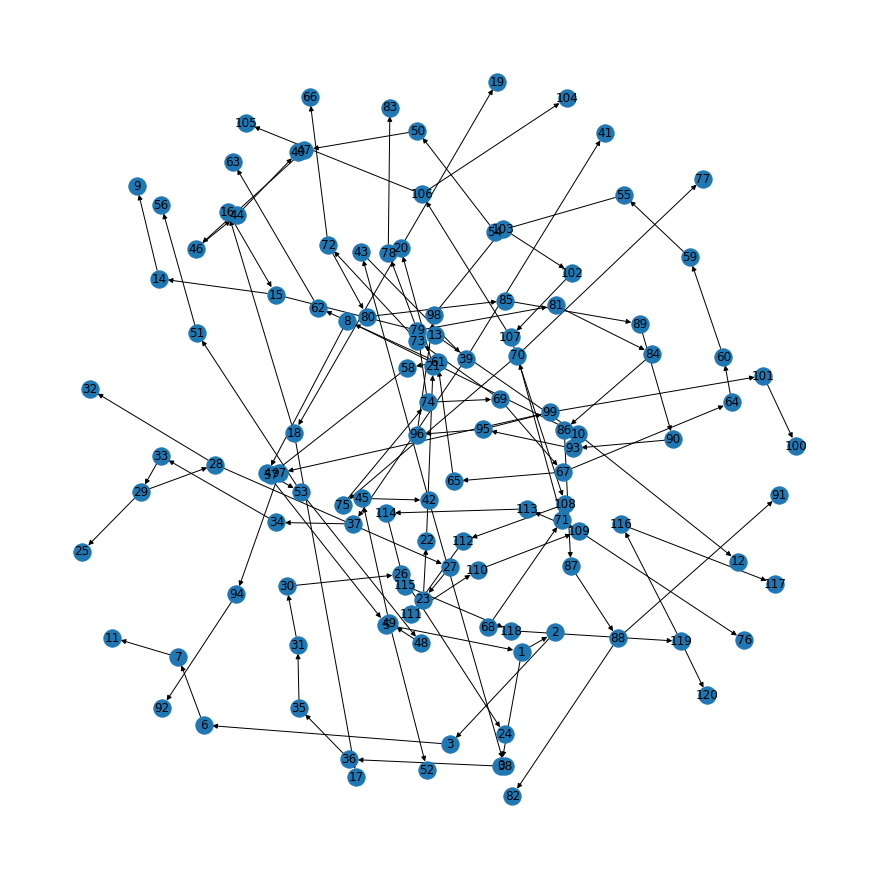

In [44]:
os.chdir("/Users/yuelanzhu/Downloads/Research/my code file")
GEcheck(7, pipesize, pipecost, 1.095E-5, 1e+5, excavation, bedding_cost_sq_ft, capital_cost_pump_station, ps_OM_cost)

In [47]:
def fixedGEcheck(cluster_labels, pipesize, pipecost, water_demand, HLmax, excavation, bedding_cost_sq_ft, capital_cost_pump_station, ps_OM_cost):

    # select highest and lowest nodes in cluster
    tank = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmax()].reset_index(drop=True)
    trem = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmin()].reset_index(drop=True)
                      
     # find label of tank node in cluster
    tank_lon = str(tank[tank['cluster.labels_'] == cluster_labels][['longitude']].iat[0,0])
    tank_lat = str(tank[tank['cluster.labels_'] == cluster_labels][['latitude']].iat[0,0])
    for i in mstree[cluster_labels].nodes():
        if str(mstree[cluster_labels].nodes[i]['pos'][0]) == tank_lon and str(mstree[cluster_labels].nodes[i]['pos'][1]) == tank_lat:
            tank_node = i                  
    #create flow direction dict
    links = list(mstree[cluster_labels].edges)
    flow_dir = {}
    for i,j in links:
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) < len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node i is nearer to tank
           flow_dir[i,j]=(i,j)
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
         # if node j is nearer to tank
           flow_dir[i,j]=(j,i) 
    # find nodes for inflow and outflow
    innode = {}
    outnode = {}
    for i,j in links:
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
           # if node j is nearer to tank
            innode.setdefault(i, [])
            innode[i].append(j)
            outnode.setdefault(j, [])
            outnode[j].append(i)
        else:
           # if node i is nearer to tank
            innode.setdefault(j, [])
            innode[j].append(i)
            outnode.setdefault(i, [])
            outnode[i].append(j)
    for i in mstree[cluster_labels].nodes():
        innode.setdefault(i,[])
        outnode.setdefault(i, [])
   # directed graph
    mstree_dir = nx.DiGraph()
    mstree_dir.add_nodes_from(mstree[cluster_labels])
    mstree_dir.add_edges_from(flow_dir.values())
    weights = {}
    for i in list(mstree_dir.edges()):
        weights[i] = None
    for i,j in flow_dir:
        if flow_dir[i,j]==(i,j):
            weights[i,j]=mstree[cluster_labels].edges[i,j]['weight']
        if flow_dir[i,j]==(j,i):
            weights[j,i]=mstree[cluster_labels].edges[i,j]['weight']
    nx.set_edge_attributes(mstree_dir, values = 1, name = 'weight')
    nx.set_edge_attributes(mstree_dir, values = weights, name = 'weight')
    # determine iterate order
    walk = {}
    for i,j in mstree_dir.edges():
        walk[i,j] = len(nx.shortest_path(mstree_dir ,source=tank_node, target=j))
    sorted_walk = dict(sorted(walk.items(), key=lambda item: item[1], reverse = True))
    # pipe flow
    pipe_flow = {}
    for i,j in sorted_walk:
        if len(outnode[j]) == 0:
            pipe_flow[i,j] = 1.095E-5
        else:
            pipe_flow[i,j] = sum(pipe_flow[m,n] for m,n in sorted_walk if m == j) + 1.095E-5
    # head loss at largest dia        
    head_loss = {}
    for i in list(mstree_dir.edges()):
        head_loss[i] = None
    for i,j in list(mstree_dir.edges()):
        head_loss[i,j] = 10700*(pipe_flow[i,j]/140)**1.852*0.6*1000*mstree_dir[i][j]["weight"]
    # flow, distance and head loss for each edge
    edge_list = {}
    for i,j in links:
        if (i,j) == flow_dir[i,j]:
            edge_list[i,j] =[pipe_flow[i,j],mstree[cluster_labels][i][j]["weight"], head_loss[i,j]]
        else:
            edge_list[j,i] =[pipe_flow[j,i],mstree[cluster_labels][i][j]["weight"], head_loss[j,i]]
   #node elevation excavation in meters
   #upper bound is arbritrary maximum depth assuming 1 foot or 0.3048 meters of cover beneath the surface is needed for the pipes
   #a lower bound variable is created but not used. In future models might need to implement that depending on the site (digging too deep for excavation is not feasible for many projects)
    cluster = df[df['cluster.labels_'] == cluster_labels]
    cluster_elv = cluster[['elevation']]
    elevation_ub = dict()
    elevation_lb = dict()
    
    #for i in range(mstree[cluster_labels].number_of_nodes()):
       # elevation_ub[i] = cluster_elv.iloc[[0]] - 0.3048
        #elevation_lb[i] = cluster_elv.iloc[[0]] - 30
        
    m = gp.Model('pipe and pump distribution')
    m.Params.timeLimit = 12000
   # binary variable indicating if at link ij pipe of diameter k is implemented
    d = m.addVars(mstree_dir.edges(), pipesize, vtype = GRB.BINARY, name = "diameter")
   #continuous variable representing the hydro loss in link ij.
    HL = m.addVars(mstree_dir.edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "hydro loss")
    # hydro gradient
    #J = m.addVars(mstree[cluster_labels].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "hydro gradient")
   # binary variable indicating if at link ij the pump of type m is implemented.
    p = m.addVars(mstree_dir.edges(), vtype = GRB.BINARY, name = "PUMP")
   #continuous variable representing the pressure injected by the pump at link ij.
    pr = m.addVars(mstree_dir.edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "PRESSURE BY PUMP")
   #pipe elevations at node i 
    #e = m.addVars(mstree_dir.nodes(), lb = 0, vtype = GRB.CONTINUOUS, name = 'In Node Elevation')
   #continuous variable representing the head pressure at node i
    H = m.addVars(mstree_dir.nodes(),lb = 0, vtype = GRB.CONTINUOUS, name = "HEAD PRESSURE")
    for i,j in mstree_dir.edges():
#Hazen Williams equation, A = 10700, C=140, P472
        #m.addConstr(J[i,j] == 
                #10700*(edge_list[i,j][0]/140)**1.852*gp.quicksum(d[i,j,k]/(k**4.8704) for k in pipesize)
               #, "Hydro loss")
        m.addConstr(HL[i,j] == 10700*(edge_list[i,j][0]/140)**1.852*gp.quicksum(d[i,j,k]/(k**4.8704) for k in pipesize)*1000*mstree_dir[i][j]["weight"])
        m.addConstr(HL[i,j] <= HLmax)
#only one pipe per edge
        m.addConstr((d.sum(i, j, '*') == 1.0), "single size chosen")
#injected pressure pr[i,j] must be less than a huge number.
        m.addConstr(pr[i,j]<=p[i,j]*10**6)
    # energy requirement
        m.addConstr(H[j] == H[i] - HL[i,j] + pr[i,j], "Energy balance")
    
        #if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) < len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node i is nearer to tank        
            #m.addConstr(H[j] == H[i] -HL[i,j] + e[i] - e[j] + pr[i,j], "Energy balance")
        #if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node j is nearer to tank        
            #m.addConstr(H[i] == H[j] -HL[i,j] + e[j] - e[i] + pr[i,j], "Energy balance")
# Velocity must be between 0.6 and 3 m/s to 30
        m.addConstr((
           edge_list[i,j][0] <= ((3.14/4)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 3), "Velocity Max Constr"+ str([i,j]))
        #m.addConstr((
           #edge_list[i,j][0] >= ((3.14/4)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 0.6), "Velocity Min Constr" + str([i,j]))  
    for i in mstree_dir.nodes():
#pipe elevation must be betwenn lb and ub
        #m.addConstr(e[i] >= elevation_lb[i], "PIPE ELV LB")
        #m.addConstr(e[i] <= elevation_ub[i], "PIPE ELV UB")
    
        m.addConstr(H[i] >= 31.646232670592248, "Min head pressure") #45 psi, covert it to m
        m.addConstr(H[i] <= 56.26, "Max head pressure") #80 psi, covert it to m
        
    m.addConstr(H[tank_node] == 31.646232670592248)
                      
                      
    # pipe cost 
    obj1 = gp.quicksum(1000 * mstree_dir[i][j]["weight"] * gp.quicksum(pipecost[str(k)] * d[i, j, k] 
                                                           for k in pipesize) for i,j in mstree_dir.edges())
    # Capital cost of pump stations
    obj2 = gp.quicksum(p.sum(i, j) * capital_cost_pump_station for i,j in mstree_dir.edges())

    #Operation and maintenance costs
    obj3 = gp.quicksum(p.sum(i, j)*ps_OM_cost for i, j in mstree_dir.edges())

    obj = obj1+obj2+obj3                  
    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()
    
    # record dia
    #count = 0
    #for i, j in mstree_dir.edges():
        #for k in range(len(pipesize)):
            #if m.getVars()[k+count].X == 1:
                #edge_list[i,j].append(pipesize[k])
        #count = count + len(pipesize)
    #d = []
    #for i,j in mstree_dir.edges():
        #d.append(edge_list[i,j][3])
    #edge_dia = {}
    #count = 0
    #for i,j in links:
        #edge_dia[i,j]=d[count]
        #count = count+1    
    
    #plot
    plt.figure(3,figsize=(12,12)) 
    plot = nx.draw(mstree_dir,width=1, with_labels=True)
    #pos = nx.spring_layout(mstree[9])
    #nx.draw_networkx(mstree[9], pos)
    #nx.draw_networkx_edge_labels(mstree_dir, pos, edge_labels=edge_dia,label_pos=0.5, font_size=8)
    
    #save the result
    current_path = os.getcwd()
    folder = current_path + '/cluster'+ str(cluster_labels)
    if not os.path.exists(folder):
        os.makedirs(folder)
    os.chdir(folder)
    
    modelname = "no e variable.csv" 
        #m.write(modelname)
    modelfile = open(modelname, "w")
    #modelfile.write("pipecost" + str(pipecost))
    modelfile.write('number of nodes: %g \n' % len(mstree[cluster_labels].nodes()))
    modelfile.write('number of edges: %g \n' % len(mstree[cluster_labels].edges()))
    #modelfile.write('number of continuous variables: %g \n' % (2*len(mstree[cluster_labels].edges()) + 2*len(mstree[cluster_labels].nodes()))
    #modelfile.write('number of binary variables: %g \n' % 2*len(mstree[cluster_labels].edges()))
    modelfile.write('capital_cost_pump_station: %g \n' % capital_cost_pump_station)
    modelfile.write('ps_OM_cost: %g \n' % ps_OM_cost)
    modelfile.write('water_demand: %g \n' % water_demand)
    modelfile.write('Solution Value: %g \n' % m.objVal)
    modelfile.write('Solution Value 1: %g \n' % obj1.getValue())
    modelfile.write('Solution Value 2: %g \n'% obj2.getValue())
    modelfile.write('Solution Value 3: %g \n'% obj3.getValue())                  
    for v in m.getVars():
        modelfile.write('%s %g \n' % (str(v.varName), v.x))
    modelfile.close()
    
    return obj.getValue(), obj1.getValue(), obj2.getValue(), obj3.getValue(), edge_list, plot
                      

Set parameter TimeLimit to value 12000
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 963 rows, 2041 columns and 5883 nonzeros
Model fingerprint: 0xc88f2980
Variable types: 361 continuous, 1680 integer (1680 binary)
Coefficient statistics:
  Matrix range     [2e-07, 1e+06]
  Objective range  [8e+01, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 4.175932e+07
Presolve removed 606 rows and 136 columns
Presolve time: 0.01s
Presolved: 357 rows, 1905 columns, 3706 nonzeros
Found heuristic solution: objective 4.038823e+07
Variable types: 239 continuous, 1666 integer (1666 binary)

Root relaxation: objective 4.255470e+05, 373 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     O

(429125.3172688657,
 87175.3172688657,
 166000.0,
 175950.0,
 {(1, 0): [1.095e-05, 0.034763158168930795, 1.5382257568437836e-08],
  (1, 2): [5.475e-05, 0.020598117266494964, 1.7956464407581438e-07],
  (5, 1): [7.664999999999999e-05, 0.042102960134877195, 6.844394847550515e-07],
  (2, 3): [4.38e-05, 0.051495293154562916, 2.9695011206133827e-07],
  (3, 6): [3.285e-05, 0.008690852058957388, 2.9416552620175965e-08],
  (4, 5): [8.759999999999999e-05,
   0.020598117266494964,
   4.2879630754586485e-07],
  (8, 4): [9.854999999999998e-05, 0.034762943826442114, 9.00066357086899e-07],
  (6, 7): [2.19e-05, 0.017381704114330775, 2.776519701134107e-08],
  (7, 11): [1.095e-05, 0.044658049721834306, 1.9760621862581685e-08],
  (10, 8): [0.00010949999999999998, 0.0253607077930826, 7.981090305132827e-07],
  (14, 9): [1.095e-05, 0.04345394770279244, 1.922782195684321e-08],
  (13, 10): [0.00013139999999999997,
   0.02274389434294683,
   1.0032504230839757e-06],
  (10, 12): [1.095e-05, 0.032998620051887244

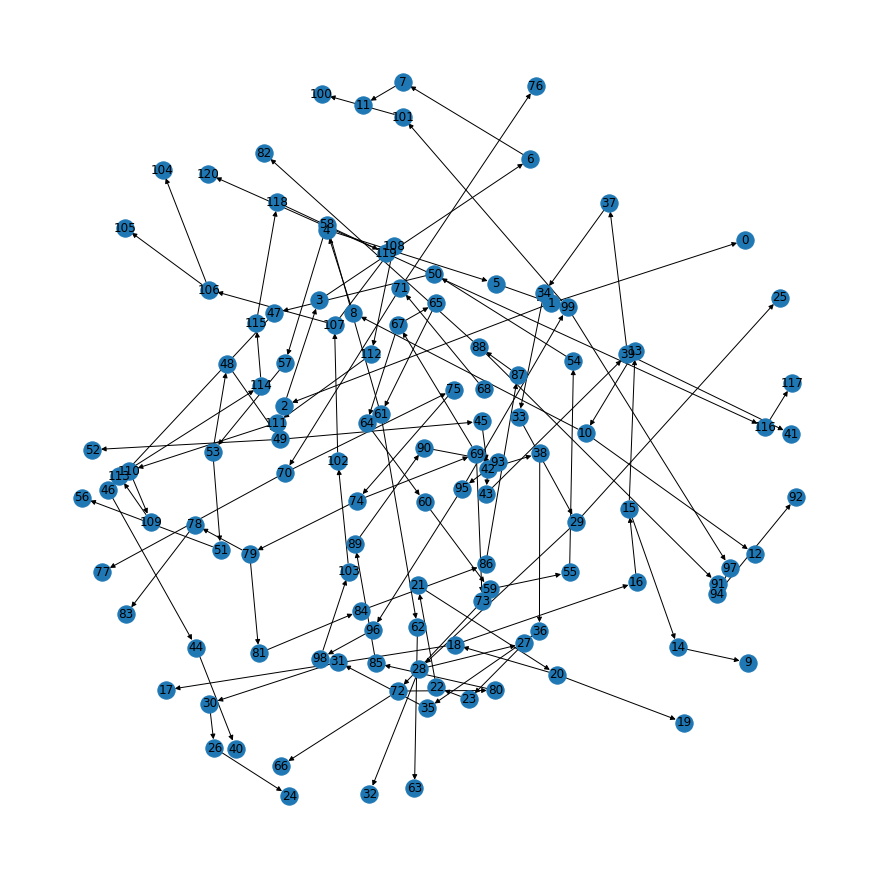

In [48]:
os.chdir("/Users/yuelanzhu/Downloads/Research/my code file")
fixedGEcheck(7, pipesize, pipecost, 1.095E-5, 1e+5, excavation, bedding_cost_sq_ft, capital_cost_pump_station, ps_OM_cost)

In [95]:
def boundcheck(bound, cluster_labels, pipesize, pipecost, water_demand, HLmax, excavation, bedding_cost_sq_ft, capital_cost_pump_station, ps_OM_cost):

    # select highest and lowest nodes in cluster
    tank = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmax()].reset_index(drop=True)
    trem = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmin()].reset_index(drop=True)
                      
     # find label of tank node in cluster
    tank_lon = str(tank[tank['cluster.labels_'] == cluster_labels][['longitude']].iat[0,0])
    tank_lat = str(tank[tank['cluster.labels_'] == cluster_labels][['latitude']].iat[0,0])
    for i in mstree[cluster_labels].nodes():
        if str(mstree[cluster_labels].nodes[i]['pos'][0]) == tank_lon and str(mstree[cluster_labels].nodes[i]['pos'][1]) == tank_lat:
            tank_node = i                  
    #create flow direction dict
    links = list(mstree[cluster_labels].edges)
    flow_dir = {}
    for i,j in links:
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) < len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node i is nearer to tank
           flow_dir[i,j]=(i,j)
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
         # if node j is nearer to tank
           flow_dir[i,j]=(j,i) 
    # find nodes for inflow and outflow
    innode = {}
    outnode = {}
    for i,j in links:
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
           # if node j is nearer to tank
            innode.setdefault(i, [])
            innode[i].append(j)
            outnode.setdefault(j, [])
            outnode[j].append(i)
        else:
           # if node i is nearer to tank
            innode.setdefault(j, [])
            innode[j].append(i)
            outnode.setdefault(i, [])
            outnode[i].append(j)
    for i in mstree[cluster_labels].nodes():
        innode.setdefault(i,[])
        outnode.setdefault(i, [])
   # directed graph
    mstree_dir = nx.DiGraph()
    mstree_dir.add_nodes_from(mstree[cluster_labels])
    mstree_dir.add_edges_from(flow_dir.values())
    weights = {}
    for i in list(mstree_dir.edges()):
        weights[i] = None
    for i,j in flow_dir:
        if flow_dir[i,j]==(i,j):
            weights[i,j]=mstree[cluster_labels].edges[i,j]['weight']
        if flow_dir[i,j]==(j,i):
            weights[j,i]=mstree[cluster_labels].edges[i,j]['weight']
    nx.set_edge_attributes(mstree_dir, values = 1, name = 'weight')
    nx.set_edge_attributes(mstree_dir, values = weights, name = 'weight')
    # determine iterate order
    walk = {}
    for i,j in mstree_dir.edges():
        walk[i,j] = len(nx.shortest_path(mstree_dir ,source=tank_node, target=j))
    sorted_walk = dict(sorted(walk.items(), key=lambda item: item[1], reverse = True))
    # pipe flow
    pipe_flow = {}
    for i,j in sorted_walk:
        if len(outnode[j]) == 0:
            pipe_flow[i,j] = 1.095E-5
        else:
            pipe_flow[i,j] = sum(pipe_flow[m,n] for m,n in sorted_walk if m == j) + 1.095E-5
    # head loss at largest dia        
    head_loss = {}
    for i in list(mstree_dir.edges()):
        head_loss[i] = None
    for i,j in list(mstree_dir.edges()):
        head_loss[i,j] = 10700*(pipe_flow[i,j]/140)**1.852*0.6*1000*mstree_dir[i][j]["weight"]
    # flow, distance and head loss for each edge
    edge_list = {}
    for i,j in links:
        if (i,j) == flow_dir[i,j]:
            edge_list[i,j] =[pipe_flow[i,j],mstree[cluster_labels][i][j]["weight"], head_loss[i,j]]
        else:
            edge_list[j,i] =[pipe_flow[j,i],mstree[cluster_labels][i][j]["weight"], head_loss[j,i]]
   #node elevation excavation in meters
   #upper bound is arbritrary maximum depth assuming 1 foot or 0.3048 meters of cover beneath the surface is needed for the pipes
   #a lower bound variable is created but not used. In future models might need to implement that depending on the site (digging too deep for excavation is not feasible for many projects)
    cluster = df[df['cluster.labels_'] == cluster_labels]
    cluster_elv = cluster[['elevation']]
    elevation_ub = dict()
    elevation_lb = dict()
    
    GE=float(str(sorted(cluster_elv.values.tolist())[120])[1:-1])
    
    for i in range(mstree[cluster_labels].number_of_nodes()):
        elevation_ub[i] = GE + bound
        elevation_lb[i] = GE - bound  
    #for i in range(mstree[cluster_labels].number_of_nodes()):
       # elevation_ub[i] = cluster_elv.iloc[[0]] - 0.3048
        #elevation_lb[i] = cluster_elv.iloc[[0]] - 30
        
    m = gp.Model('pipe and pump distribution')
    m.Params.timeLimit = 12000
   # binary variable indicating if at link ij pipe of diameter k is implemented
    d = m.addVars(mstree_dir.edges(), pipesize, vtype = GRB.BINARY, name = "diameter")
   #continuous variable representing the hydro loss in link ij.
    HL = m.addVars(mstree_dir.edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "hydro loss")
    # hydro gradient
    #J = m.addVars(mstree[cluster_labels].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "hydro gradient")
   # binary variable indicating if at link ij the pump of type m is implemented.
    p = m.addVars(mstree_dir.edges(), vtype = GRB.BINARY, name = "PUMP")
   #continuous variable representing the pressure injected by the pump at link ij.
    pr = m.addVars(mstree_dir.edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "PRESSURE BY PUMP")
   #pipe elevations at node i 
    e = m.addVars(mstree_dir.nodes(), lb = 0, vtype = GRB.CONTINUOUS, name = 'In Node Elevation')
   #continuous variable representing the head pressure at node i
    H = m.addVars(mstree_dir.nodes(),lb = 0, vtype = GRB.CONTINUOUS, name = "HEAD PRESSURE")
    for i,j in mstree_dir.edges():
#Hazen Williams equation, A = 10700, C=140, P472
        #m.addConstr(J[i,j] == 
                #10700*(edge_list[i,j][0]/140)**1.852*gp.quicksum(d[i,j,k]/(k**4.8704) for k in pipesize)
               #, "Hydro loss")
        m.addConstr(HL[i,j] == 10700*(edge_list[i,j][0]/140)**1.852*gp.quicksum(d[i,j,k]/(k**4.8704) for k in pipesize)*1000*mstree_dir[i][j]["weight"])
        m.addConstr(HL[i,j] <= HLmax)
#only one pipe per edge
        m.addConstr((d.sum(i, j, '*') == 1.0), "single size chosen")
#injected pressure pr[i,j] must be less than a huge number.
        m.addConstr(pr[i,j]<=p[i,j]*10**6)
    # energy requirement
        m.addConstr(H[j] == H[i] - HL[i,j] + e[i] - e[j] + pr[i,j], "Energy balance")
    
        #if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) < len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node i is nearer to tank        
            #m.addConstr(H[j] == H[i] -HL[i,j] + e[i] - e[j] + pr[i,j], "Energy balance")
        #if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node j is nearer to tank        
            #m.addConstr(H[i] == H[j] -HL[i,j] + e[j] - e[i] + pr[i,j], "Energy balance")
# Velocity must be between 0.6 and 3 m/s to 30
        m.addConstr((
           edge_list[i,j][0] <= ((3.14/4)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 3), "Velocity Max Constr"+ str([i,j]))
        #m.addConstr((
           #edge_list[i,j][0] >= ((3.14/4)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 0.6), "Velocity Min Constr" + str([i,j]))  
    for i in mstree_dir.nodes():
#pipe elevation must be betwenn lb and ub
        m.addConstr(e[i] >= elevation_lb[i], "PIPE ELV LB")
        m.addConstr(e[i] <= elevation_ub[i], "PIPE ELV UB")
    
        m.addConstr(H[i] >= 31.646232670592248, "Min head pressure") #45 psi, covert it to m
        m.addConstr(H[i] <= 56.26, "Max head pressure") #80 psi, covert it to m
        
    m.addConstr(H[tank_node] == 31.646232670592248)
                      
                      
    # pipe cost 
    obj1 = gp.quicksum(1000 * mstree_dir[i][j]["weight"] * gp.quicksum(pipecost[str(k)] * d[i, j, k] 
                                                           for k in pipesize) for i,j in mstree_dir.edges())
    # Capital cost of pump stations
    obj2 = gp.quicksum(p.sum(i, j) * capital_cost_pump_station for i,j in mstree_dir.edges())

    #Operation and maintenance costs
    obj3 = gp.quicksum(p.sum(i, j)*ps_OM_cost for i, j in mstree_dir.edges())

    obj = obj1+obj2+obj3                  
    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()
    
    # record dia
    #count = 0
    #for i, j in mstree_dir.edges():
        #for k in range(len(pipesize)):
            #if m.getVars()[k+count].X == 1:
                #edge_list[i,j].append(pipesize[k])
        #count = count + len(pipesize)
    #d = []
    #for i,j in mstree_dir.edges():
        #d.append(edge_list[i,j][3])
    #edge_dia = {}
    #count = 0
    #for i,j in links:
        #edge_dia[i,j]=d[count]
        #count = count+1    
    
    #plot
    plt.figure(3,figsize=(12,12)) 
    plot = nx.draw(mstree_dir,width=1, with_labels=True)
    #pos = nx.spring_layout(mstree[9])
    #nx.draw_networkx(mstree[9], pos)
    #nx.draw_networkx_edge_labels(mstree_dir, pos, edge_labels=edge_dia,label_pos=0.5, font_size=8)
    
    #save the result
    current_path = os.getcwd()
    folder = current_path +'/cluster' + str(cluster_labels) + '/cluster'+ str(cluster_labels) + '_' + str(round(GE))
    if not os.path.exists(folder):
        os.makedirs(folder)
    os.chdir(folder)
    
    modelname = str(round(GE)) + "_" + str(bound) + ".csv" 
        #m.write(modelname)
    modelfile = open(modelname, "w")
    #modelfile.write("pipecost" + str(pipecost))
    modelfile.write('range: %g \n' % bound)
    modelfile.write('number of nodes: %g \n' % len(mstree[cluster_labels].nodes()))
    modelfile.write('number of edges: %g \n' % len(mstree[cluster_labels].edges()))
    #modelfile.write('number of continuous variables: %g \n' % (2*len(mstree[cluster_labels].edges()) + 2*len(mstree[cluster_labels].nodes()))
    #modelfile.write('number of binary variables: %g \n' % 2*len(mstree[cluster_labels].edges()))
    modelfile.write('capital_cost_pump_station: %g \n' % capital_cost_pump_station)
    modelfile.write('ps_OM_cost: %g \n' % ps_OM_cost)
    modelfile.write('water_demand: %g \n' % water_demand)
    modelfile.write('Solution Value: %g \n' % m.objVal)
    modelfile.write('Solution Value 1: %g \n' % obj1.getValue())
    modelfile.write('Solution Value 2: %g \n'% obj2.getValue())
    modelfile.write('Solution Value 3: %g \n'% obj3.getValue())                  
    for v in m.getVars():
        modelfile.write('%s %g \n' % (str(v.varName), v.x))
    modelfile.close()
    
    return obj.getValue(), obj1.getValue(), obj2.getValue(), obj3.getValue(), edge_list, plot
                      

Set parameter TimeLimit to value 12000
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1205 rows, 2162 columns and 6365 nonzeros
Model fingerprint: 0xbf91b856
Variable types: 482 continuous, 1680 integer (1680 binary)
Coefficient statistics:
  Matrix range     [2e-07, 1e+06]
  Objective range  [8e+01, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 845 rows and 241 columns
Presolve time: 0.01s
Presolved: 360 rows, 1921 columns, 3735 nonzeros
Variable types: 241 continuous, 1680 integer (1680 binary)
Found heuristic solution: objective 3.977073e+07

Root relaxation: objective 1.018621e+05, 386 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  

Thread count was 8 (of 8 available processors)

Solution count 8: 73987.8 74000.1 74008 ... 4.1801e+07

Optimal solution found (tolerance 1.00e-04)
Best objective 7.398782593381e+04, best bound 7.398675263637e+04, gap 0.0015%
Set parameter TimeLimit to value 12000
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1205 rows, 2162 columns and 6365 nonzeros
Model fingerprint: 0xa6bc20e4
Variable types: 482 continuous, 1680 integer (1680 binary)
Coefficient statistics:
  Matrix range     [2e-07, 1e+06]
  Objective range  [8e+01, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 4.180099e+07
Presolve removed 845 rows and 241 columns
Presolve time: 0.01s
Presolved: 360 rows, 1921 columns, 3720 nonzeros
Variable typ

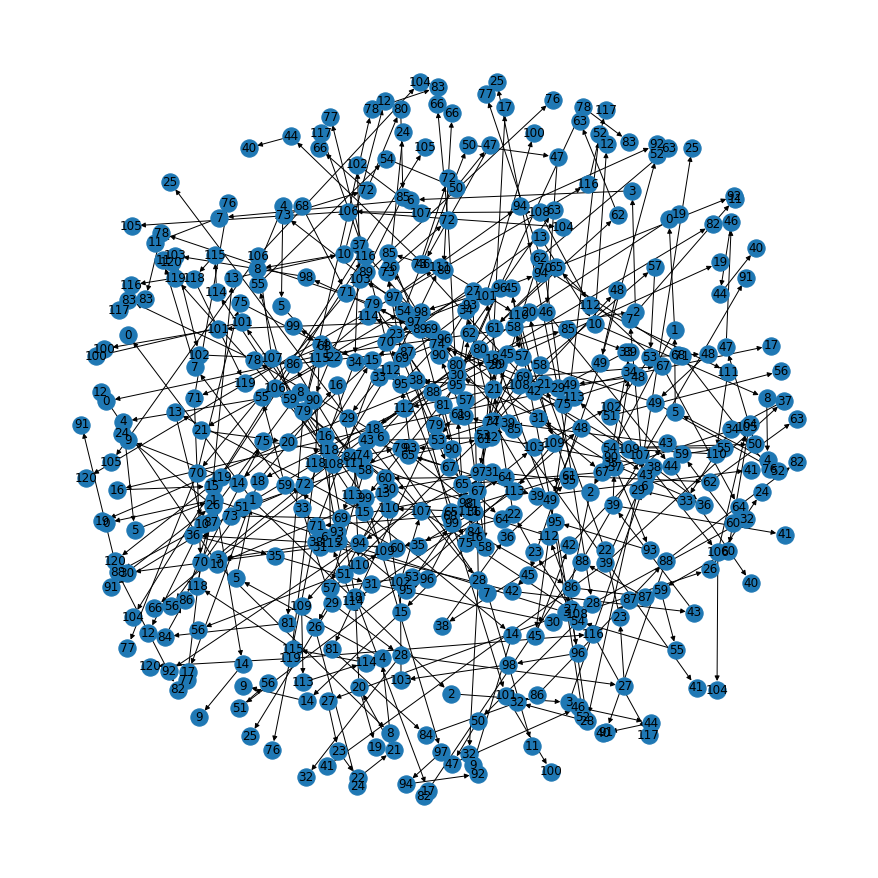

In [96]:
os.chdir("/Users/yuelanzhu/Downloads/Research/my code file")
for i in range(1,40,10):
    os.chdir("/Users/yuelanzhu/Downloads/Research/my code file")
    boundcheck(i, 7, pipesize, pipecost, 1.095E-5, 1e+5, excavation, bedding_cost_sq_ft, capital_cost_pump_station, ps_OM_cost)

Set parameter TimeLimit to value 12000
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1205 rows, 2162 columns and 6365 nonzeros
Model fingerprint: 0xf99391fd
Variable types: 482 continuous, 1680 integer (1680 binary)
Coefficient statistics:
  Matrix range     [2e-07, 1e+06]
  Objective range  [8e+01, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 845 rows and 241 columns
Presolve time: 0.01s
Presolved: 360 rows, 1921 columns, 3740 nonzeros
Variable types: 241 continuous, 1680 integer (1680 binary)
Found heuristic solution: objective 3.977073e+07

Root relaxation: objective 1.062774e+05, 407 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  


     0     0 105731.350    0    5 3.9771e+07 105731.350   100%     -    0s
H    0     0                    1109572.9082 105731.350  90.5%     -    0s
H    0     0                    767653.90276 105731.350  86.2%     -    0s
H    0     0                    767448.25337 105731.350  86.2%     -    0s
H    0     0                    434632.94721 105731.350  75.7%     -    0s
     0     0 124638.269    0    8 434632.947 124638.269  71.3%     -    0s
H    0     0                    432243.55092 124638.269  71.2%     -    0s
H    0     0                    429405.19548 272938.070  36.4%     -    0s
     0     0 272938.070    0   10 429405.195 272938.070  36.4%     -    0s
     0     0 302388.052    0   10 429405.195 302388.052  29.6%     -    0s
H    0     0                    407924.81866 302388.052  25.9%     -    0s
H    0     0                    393878.55269 312331.157  20.7%     -    0s
     0     0 389174.353    0    8 393878.553 389174.353  1.19%     -    0s
H    0     0            

     0     0 364488.941    0   13 364888.778 364488.941  0.11%     -    0s
     0     0 364488.941    0   11 364888.778 364488.941  0.11%     -    0s
     0     0 364488.941    0   48 364888.778 364488.941  0.11%     -    0s
H    0     0                    364824.30410 364488.941  0.09%     -    0s
     0     0 364488.941    0   52 364824.304 364488.941  0.09%     -    0s
     0     0 364488.941    0   54 364824.304 364488.941  0.09%     -    0s
H    0     0                    364769.79323 364488.941  0.08%     -    0s
     0     0 364491.559    0   73 364769.793 364491.559  0.08%     -    0s
     0     0 364492.686    0   18 364769.793 364492.686  0.08%     -    0s
     0     0 364492.686    0   18 364769.793 364492.686  0.08%     -    0s
     0     0 364510.879    0   15 364769.793 364510.879  0.07%     -    0s
     0     0 364510.879    0   16 364769.793 364510.879  0.07%     -    0s
     0     0 364510.879    0   13 364769.793 364510.879  0.07%     -    0s
     0     0 364556.965  

         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 845 rows and 241 columns
Presolve time: 0.01s
Presolved: 360 rows, 1921 columns, 3737 nonzeros
Variable types: 241 continuous, 1680 integer (1680 binary)
Found heuristic solution: objective 3.977073e+07

Root relaxation: objective 1.051167e+05, 380 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 105116.673    0    5 3.9771e+07 105116.673   100%     -    0s
H    0     0                    1471992.2255 105116.673  92.9%     -    0s
H    0     0                    767653.90276 105116.673  86.3%     -    0s
H    0     0                    767360.32172 105116.673  86.3%     -    0s
H    0     0                    433699.65059 105116.673  75.8%     -    0s
     0     0 129666.777    0    8 433699.651 129666.777 

Set parameter TimeLimit to value 12000
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1205 rows, 2162 columns and 6365 nonzeros
Model fingerprint: 0x1072543e
Variable types: 482 continuous, 1680 integer (1680 binary)
Coefficient statistics:
  Matrix range     [2e-07, 1e+06]
  Objective range  [8e+01, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 845 rows and 241 columns
Presolve time: 0.01s
Presolved: 360 rows, 1921 columns, 3736 nonzeros
Variable types: 241 continuous, 1680 integer (1680 binary)
Found heuristic solution: objective 3.977073e+07

Root relaxation: objective 1.047080e+05, 388 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  

Thread count was 8 (of 8 available processors)

Solution count 10: 287418 287443 287462 ... 427644

Optimal solution found (tolerance 1.00e-04)
Best objective 2.874181972907e+05, best bound 2.873921543706e+05, gap 0.0091%


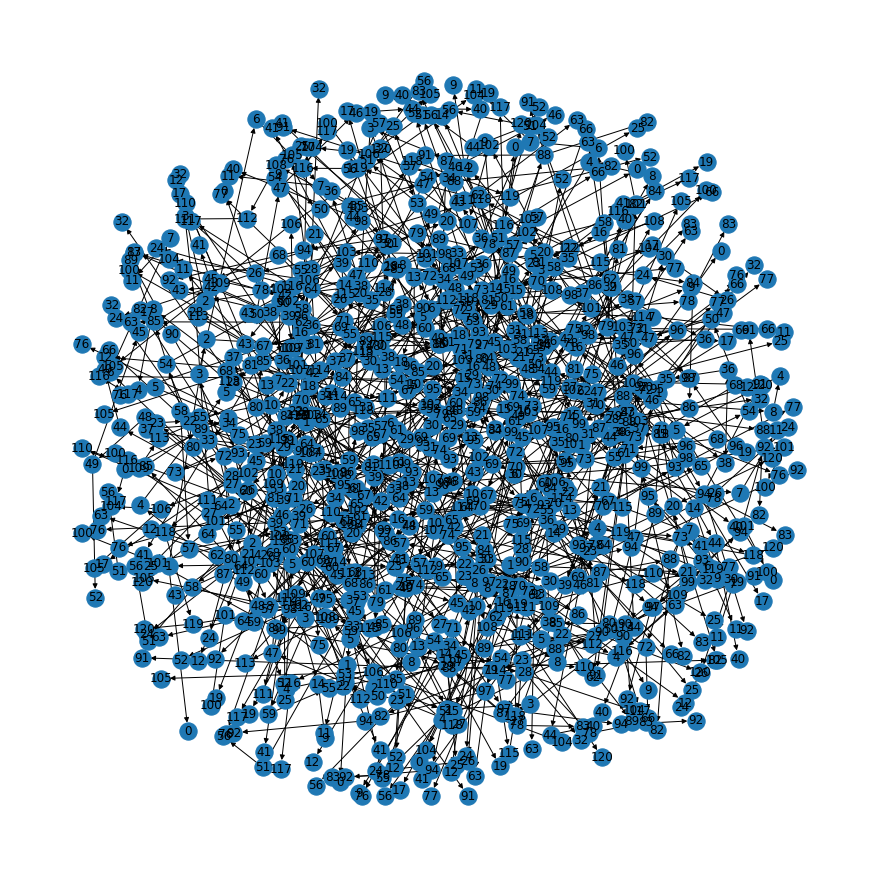

In [97]:
os.chdir("/Users/yuelanzhu/Downloads/Research/my code file")
for i in np.arange(0.1,1,0.1):
    os.chdir("/Users/yuelanzhu/Downloads/Research/my code file")
    boundcheck(i, 7, pipesize, pipecost, 1.095E-5, 1e+5, excavation, bedding_cost_sq_ft, capital_cost_pump_station, ps_OM_cost)